# Using pgmpy for Bayesian inference

Documentation and examples for the package are available on [pgmpy.org](http://pgmpy.org/index.html). To [install](https://github.com/pgmpy/pgmpy#installation) using conda/mamba you need to add the `ankurankan` channel and install `pgmpy`. E.g. in the `environment.yml`:

``` yaml
channels:
  - conda-forge
  - ankurankan
dependencies:
  - ...
  - pgmpy
```

or you can use the command:

```bash
mamba install -c ankurankan pgmpy
```

For more details on the API see [Creating discrete Bayesian Networks](https://pgmpy.org/examples/Creating%20a%20Discrete%20Bayesian%20Network.html) and [Inference in Discrete Bayesian Network](https://pgmpy.org/examples/Inference%20in%20Discrete%20Bayesian%20Networks.html) in the [pgmpy documentation](http://pgmpy.org/index.html).

In [1]:
import itertools

In [2]:
import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

## Compact representation

First we consider the example discussed in class:

![](docs/assets/wumpus-stuck.svg)

We use the variable $b_{i,j}$ to represent the fact that in the cell $i,j$ the hunter feels the breeze, and $p_{i,j}$ to indicate whether in the cell ${i,j}$ there is a pit.

For the time being, the observations are summarised in the single $b$ boolean variable:

$$b \iff \neg b_{1,1} \land b_{1,2} \land b_{2,1}$$

Since we know already that $\neg p_{1,1} \land \neg p_{1,2} \land \neg p_{2,1}$, we can simplify the model by considering only the variables $b, p_{1,3}, p_{2,2}, p_{3,1}$. Moreover, given the configuration, $b$ depends only on *unknown* $p_{i,j}$ of cells which are close to $(1,1), (1,2), (2,1)$, that is $p_{1,3}, p_{2,2}, p_{3,1}$.

We use the [`BayesianNetwork`](https://pgmpy.org/examples/Creating%20a%20Discrete%20Bayesian%20Network.html#Step-1:-Define-the-model-structure) class to create the structure of the model:

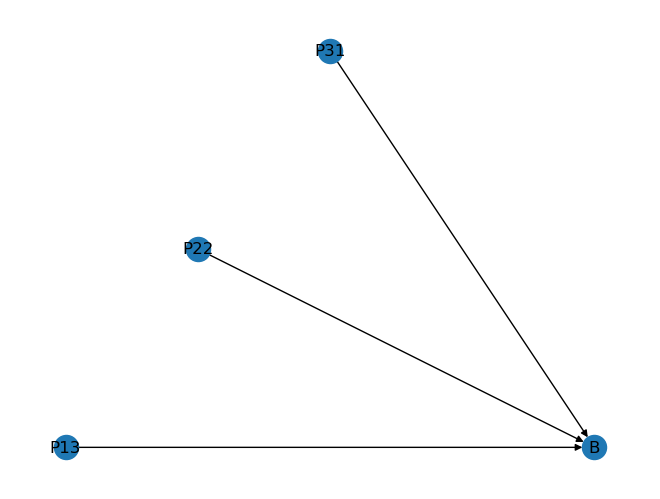

In [3]:
model = BayesianNetwork([('P13', 'B'), ('P22', 'B'), ('P31', 'B')])
nx.draw(model, pos=nx.planar_layout(model), with_labels=True)

Next we need to associate the conditional probability distribution tables (CPDs) to the nodes (see also the [pgmpy tutorial](https://pgmpy.org/examples/Creating%20a%20Discrete%20Bayesian%20Network.html#Step-2:-Define-the-CPDs)).

### Define the $p_{ij}$

Each $p_{ij}$ is an independent variable which, by the description of the Wumpus game, has 20% probability of being true; therefore the associated table is:

| $$P(p_{i,j})$$ | $$P(\neg p_{i,j})$$ |
|-------------|------------------|
| 0.2         | 0.8              |

In `pgmpy` we can use the `TabularCPD` class which takes as initialisation arguments the variable name, cardinality (2 because it's boolean), and the labels associated to each of the values that the variable can take as a dictionary.

In `pgmpy` the table is transposed w.r.t. the layout above, and each row corresponds to a different label:

|                |     |
|----------------|-----|
| $p_{i,j}$=True  | 0.2 |
| $p_{i,j}$=False | 0.8 |


therefore the probability values are included as a list of rows:

```python
[[0.2], [0.8]]
```

In [4]:
p_cpds = {}
for i in range(1,4):
    for j in range(1,4):
        p_cpds[(i, j)] = TabularCPD(
            variable=f'P{i}{j}', variable_card=2, 
            values=[[0.2], [0.8]], 
            state_names={f'P{i}{j}': [True, False]})

print(p_cpds[(1,3)])

+------------+-----+
| P13(True)  | 0.2 |
+------------+-----+
| P13(False) | 0.8 |
+------------+-----+


### Define $b$

The tables for the $b_{i,j}$ variables depend on the values of $p_{i,j}$, where true corresponds to 1.0 and false to 0.0. Given that:

$$b_{1,1} \iff p_{1,2}\lor p_{2,1}$$
$$b_{1,2} \iff p_{1,1}\lor p_{2,2}\lor p_{1,3}$$
$$b_{2,1} \iff p_{1,1}\lor p_{2,2}\lor p_{3,1}$$

and $b \iff \neg b_{1,1} \land b_{1,2} \land b_{2,1}$

$$b \iff (p_{2,2}\lor p_{1,3})\land(p_{2,2}\lor p_{3,1})$$

because $\neg p_{1,1}, \neg p_{1,2}, \neg p_{2,1}$.

In this case the CPD for $b$ depends on three variables, so the table looks like:

|           |      |       |     |       |       |
|-----------|------|-------|-----|-------|-------|
| $p_{1,3}$ | True | True  | ... | False | False |
| $p_{2,2}$ | True | True  | ... | False | False |
| $p_{3,1}$ | True | False | ... | True  | False |
| $b$=True  | 1.0  | 1.0   | ... | 0.0   | 0.0   |
| $b$=False | 0.0  | 0.0   | ... | 1.0   | 1.0   |



In [5]:
def b_col(p13, p22, p31):
    return (1.0, 0.0) if (p13 or p22) and (p22 or p31) else (0.0, 1.0)

b_cpd = TabularCPD(
    variable='B', variable_card=2,
    values=tuple(zip(*[b_col(p13, p22, p31) for p13, p22, p31 in itertools.product((True, False), repeat=3)])),
    evidence=['P13', 'P22', 'P31'],
    evidence_card=[2, 2, 2],
    state_names={
        'B': [True, False],
        'P13': [True, False],
        'P22': [True, False],
        'P31': [True, False]
    })

print(b_cpd)

+----------+-----------+------------+-----+------------+------------+
| P13      | P13(True) | P13(True)  | ... | P13(False) | P13(False) |
+----------+-----------+------------+-----+------------+------------+
| P22      | P22(True) | P22(True)  | ... | P22(False) | P22(False) |
+----------+-----------+------------+-----+------------+------------+
| P31      | P31(True) | P31(False) | ... | P31(True)  | P31(False) |
+----------+-----------+------------+-----+------------+------------+
| B(True)  | 1.0       | 1.0        | ... | 0.0        | 0.0        |
+----------+-----------+------------+-----+------------+------------+
| B(False) | 0.0       | 0.0        | ... | 1.0        | 1.0        |
+----------+-----------+------------+-----+------------+------------+


### Adding the CPDs

Now we can add the CPD to the model and check that everything fits using the `BayesianNetwork.check_model` method:

In [6]:
model.add_cpds(b_cpd, p_cpds[(1,3)], p_cpds[(2,2)], p_cpds[(3,1)])
model.check_model()

True

### Querying the model

Since the model is rather small, we can use an exact inference method, e.g. [variable elimination](https://pgmpy.org/examples/Inference%20in%20Discrete%20Bayesian%20Networks.html#Step-2:-Initialize-the-inference-class):

In [7]:
infer = VariableElimination(model)

Let's see the probability of the different cells, given that $b$ is assumed to be true:

In [8]:
for v in ('P13', 'P22', 'P31'):
    print(infer.query([v], evidence={'B': True}, show_progress=False))

+------------+------------+
| P13        |   phi(P13) |
+============+============+
| P13(True)  |     0.3103 |
+------------+------------+
| P13(False) |     0.6897 |
+------------+------------+
+------------+------------+
| P22        |   phi(P22) |
+============+============+
| P22(True)  |     0.8621 |
+------------+------------+
| P22(False) |     0.1379 |
+------------+------------+
+------------+------------+
| P31        |   phi(P31) |
+============+============+
| P31(True)  |     0.3103 |
+------------+------------+
| P31(False) |     0.6897 |
+------------+------------+


## All variables

Now we consider all the variables in the domain, i.e. the $b_{i,j}$. We start by defining a couple of functions to help defining the CPDs:

In [9]:
from typing import Tuple

def cpd_values(bool_fn, arity) -> Tuple[Tuple[float]]:
    def bool_to_prob(*args) -> Tuple[float, float]:
        return (1.0, 0.0) if bool_fn(*args) else (0.0, 1.0)
    
    return tuple(zip(*[bool_to_prob(*ps) for ps in itertools.product((True, False), repeat=arity)]))

def wumpus_cpd(name, evidence, bool_fn):
    return TabularCPD(
        variable=name, variable_card=2,
        values=cpd_values(bool_fn, len(evidence)),
        evidence=evidence, evidence_card=[2] * len(evidence),
        state_names={n: [True, False] for n in [name] + evidence}
    )

![](docs/assets/wumpus-stuck.svg)

In [10]:
b_cpds = {
    (1,1): wumpus_cpd('B11', ['P12', 'P21'], lambda p12, p21: (p12 or p21)),
    (1,2): wumpus_cpd('B12', ['P11', 'P13', 'P22'], lambda p11, p13, p22: (p11 or p13 or p22)),
    (2,1): wumpus_cpd('B21', ['P11', 'P22', 'P31'], lambda p11, p22, p31: (p11 or p22 or p31))
}

for t in b_cpds.values():
    print(t)


+------------+-----------+------------+------------+------------+
| P12        | P12(True) | P12(True)  | P12(False) | P12(False) |
+------------+-----------+------------+------------+------------+
| P21        | P21(True) | P21(False) | P21(True)  | P21(False) |
+------------+-----------+------------+------------+------------+
| B11(True)  | 1.0       | 1.0        | 1.0        | 0.0        |
+------------+-----------+------------+------------+------------+
| B11(False) | 0.0       | 0.0        | 0.0        | 1.0        |
+------------+-----------+------------+------------+------------+
+------------+-----------+-----+------------+------------+
| P11        | P11(True) | ... | P11(False) | P11(False) |
+------------+-----------+-----+------------+------------+
| P13        | P13(True) | ... | P13(False) | P13(False) |
+------------+-----------+-----+------------+------------+
| P22        | P22(True) | ... | P22(True)  | P22(False) |
+------------+-----------+-----+------------+-------

In [11]:
exp_model = BayesianNetwork()

for b in b_cpds.values():
    for e in b.get_evidence():
        exp_model.add_edge(e, b.variable)
        
exp_model.add_nodes_from([p.variable for p in p_cpds.values()])
        
exp_model.add_cpds(*b_cpds.values())
exp_model.add_cpds(*p_cpds.values())

assert exp_model.check_model()

exp_infer = VariableElimination(exp_model)

In [12]:
exp_model.get_cpds()

[<TabularCPD representing P(B11:2 | P12:2, P21:2) at 0x12e333640>,
 <TabularCPD representing P(B12:2 | P11:2, P13:2, P22:2) at 0x12e332c80>,
 <TabularCPD representing P(B21:2 | P11:2, P22:2, P31:2) at 0x12e332b60>,
 <TabularCPD representing P(P11:2) at 0x12e333ac0>,
 <TabularCPD representing P(P12:2) at 0x12e366f80>,
 <TabularCPD representing P(P13:2) at 0x12e366650>,
 <TabularCPD representing P(P21:2) at 0x12e366fb0>,
 <TabularCPD representing P(P22:2) at 0x12e366680>,
 <TabularCPD representing P(P23:2) at 0x12e3666b0>,
 <TabularCPD representing P(P31:2) at 0x12e366f20>,
 <TabularCPD representing P(P32:2) at 0x12e366710>,
 <TabularCPD representing P(P33:2) at 0x12e3668f0>]

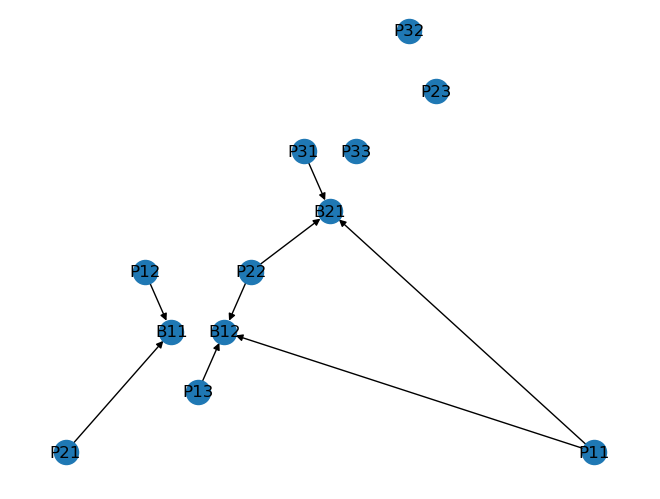

In [13]:
# this requires matplotlib
nx.draw(exp_model, pos=nx.planar_layout(exp_model), with_labels=True)


In [14]:
for v in ('P13', 'P22', 'P31'):
    print(exp_infer.query([v], evidence={'B11': False, 'B12': True, 'B21': True, 'P11': False, 'P12': False, 'P21': False}, show_progress=False))
    

+------------+------------+
| P13        |   phi(P13) |
+============+============+
| P13(True)  |     0.3103 |
+------------+------------+
| P13(False) |     0.6897 |
+------------+------------+
+------------+------------+
| P22        |   phi(P22) |
+============+============+
| P22(True)  |     0.8621 |
+------------+------------+
| P22(False) |     0.1379 |
+------------+------------+
+------------+------------+
| P31        |   phi(P31) |
+============+============+
| P31(True)  |     0.3103 |
+------------+------------+
| P31(False) |     0.6897 |
+------------+------------+


As expected, the result is the same as the one for the compact model above.

## Apply probabilistic reasoning

Consider the example we addressed with SMT techniques in a previous lab:

```
+---+---+---+---+
|   |  B|  ?|  ?|
|   |   |   |   |
+---+---+---+---+
|   |  B|  ?|  B|
|   |   |   |   |
+---+---+---+---+
|  B|  ?|  ?|  ?|
|   |   |   |   |
+---+---+---+---+
|   |  B|S  |   |
| A |   |   |   |
+---+---+---+---+
```

Use the technique demonstrated above to calculate the probability of having a pit in each of the "unknown" cells (the ones with a question mark). Compare the results with the ones obtained using SMT.

You can add your code below in this notebook, or create separate document(s)/file(s).

In [4]:
p_cpds = {}
for i in range(1,5):
    for j in range(1,5):
        p_cpds[(i, j)] = TabularCPD(
            variable=f'P{i}{j}', variable_card=2, 
            values=[[0.2], [0.8]], 
            state_names={f'P{i}{j}': [True, False]})

In [5]:
def cpd_values(bool_fn, arity):
    def bool_to_prob(*args):
        return (1.0, 0.0) if bool_fn(*args) else (0.0, 1.0)
    
    return tuple(zip(*[bool_to_prob(*ps) for ps in itertools.product((True, False), repeat=arity)]))

def wumpus_cpd(name, evidence, bool_fn):
    return TabularCPD(
        variable=name, variable_card=2,
        values=cpd_values(bool_fn, len(evidence)),
        evidence=evidence, evidence_card=[2] * len(evidence),
        state_names={n: [True, False] for n in [name] + evidence}
    )

In [8]:
b_cpds = {
    (1,1): wumpus_cpd('B11', ['P12', 'P21'], lambda p12, p21: (p12 or p21)),
    (1,2): wumpus_cpd('B12', ['P11', 'P13', 'P22'], lambda p11, p13, p22: (p11 or p13 or p22)),
    (1,3): wumpus_cpd('B13', ['P12', 'P14', 'P23'], lambda p12, p14, p23: (p12 or p14 or p23)),
    (1,4): wumpus_cpd('B14', ['P13', 'P24'], lambda p13, p24: (p13 or p24)),
    
    (2,1): wumpus_cpd('B21', ['P11', 'P22', 'P31'], lambda p11, p22, p31: (p11 or p22 or p31)),
    (2,2): wumpus_cpd('B22', ['P12', 'P21', 'P32', 'P23'], lambda p12, p21, p32, p23: (p12 or p21 or p32 or p23)),
    (2,3): wumpus_cpd('B23', ['P13', 'P24', 'P33', 'P22'], lambda p13, p24, p33, p22: (p13 or p24 or p33 or p22)),
    (2,4): wumpus_cpd('B24', ['P14', 'P23', 'P34'], lambda p14, p23, p34: (p14 or p23 or p34)),

    (3,1): wumpus_cpd('B31', ['P21', 'P32', 'P41'], lambda p21, p32, p41: (p21 or p32 or p41)),
    (3,2): wumpus_cpd('B32', ['P22', 'P33', 'P42', 'P31'], lambda p22, p33, p42, p31: (p22 or p33 or p42 or p31)),
    (3,3): wumpus_cpd('B33', ['P23', 'P34', 'P43', 'P32'], lambda p23, p34, p43, p32: (p23 or p34 or p43 or p32)),
    (3,4): wumpus_cpd('B34', ['P24', 'P33', 'P34'], lambda p24, p33, p34: (p24 or p33 or p34)),
    
    (4,1): wumpus_cpd('B41', ['P31', 'P42'], lambda p31, p42: (p31 or p42)),
    (4,2): wumpus_cpd('B42', ['P41', 'P32', 'P43'], lambda p41, p32, p43: (p41 or p32 or p43)),
    (4,3): wumpus_cpd('B43', ['P42', 'P33', 'P44'], lambda p42, p33, p44: (p42 or p33 or p44)),
    (4,4): wumpus_cpd('B44', ['P43', 'P34'], lambda p43, p34: (p43 or p34)),
}

# for t in b_cpds.values():
#     print(t)

In [9]:
exp_model = BayesianNetwork()

for b in b_cpds.values():
    for e in b.get_evidence():
        exp_model.add_edge(e, b.variable)
        
exp_model.add_nodes_from([p.variable for p in p_cpds.values()])

exp_model.add_cpds(*b_cpds.values())
exp_model.add_cpds(*p_cpds.values())

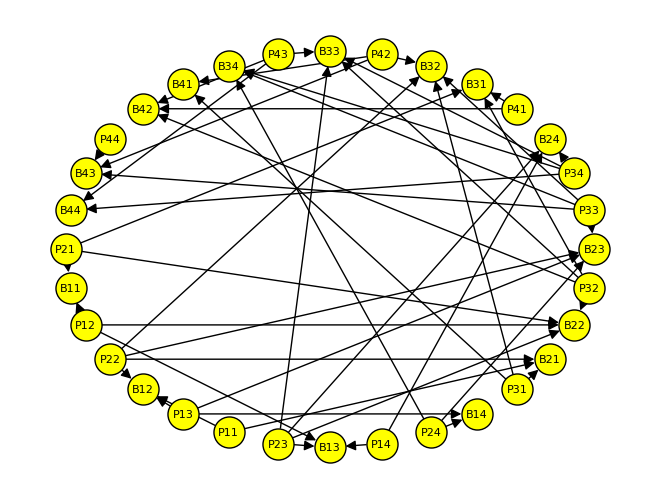

In [10]:
nx.draw(
    exp_model, 
    pos=nx.shell_layout(exp_model), 
    with_labels=True,
    node_size=500,
    node_color='yellow',
    edgecolors='k',
    edge_color='k',
    arrowsize=15,
    font_size=8
)

In [11]:
assert exp_model.check_model()

exp_infer = VariableElimination(exp_model)
exp_model.get_cpds()

[<TabularCPD representing P(B11:2 | P12:2, P21:2) at 0x12f03bf10>,
 <TabularCPD representing P(B12:2 | P11:2, P13:2, P22:2) at 0x12f038100>,
 <TabularCPD representing P(B13:2 | P12:2, P14:2, P23:2) at 0x12f038130>,
 <TabularCPD representing P(B14:2 | P13:2, P24:2) at 0x12f038160>,
 <TabularCPD representing P(B21:2 | P11:2, P22:2, P31:2) at 0x12f038190>,
 <TabularCPD representing P(B22:2 | P12:2, P21:2, P32:2, P23:2) at 0x12f03bf40>,
 <TabularCPD representing P(B23:2 | P13:2, P24:2, P33:2, P22:2) at 0x12f038220>,
 <TabularCPD representing P(B24:2 | P14:2, P23:2, P34:2) at 0x12f038250>,
 <TabularCPD representing P(B31:2 | P21:2, P32:2, P41:2) at 0x12f0382b0>,
 <TabularCPD representing P(B32:2 | P22:2, P33:2, P42:2, P31:2) at 0x12f038280>,
 <TabularCPD representing P(B33:2 | P23:2, P34:2, P43:2, P32:2) at 0x12f038340>,
 <TabularCPD representing P(B34:2 | P24:2, P33:2, P34:2) at 0x12f038370>,
 <TabularCPD representing P(B41:2 | P31:2, P42:2) at 0x12f0383d0>,
 <TabularCPD representing P(B42

In [12]:
evidence = {
    'B11': 0, 'B12': 1, 'B13': 0, 'B14': 0, 
    'B21': 1,           'B23': 1, 'B24': 1,
    'B31': 1,
    'B41': 0,           'B43': 1, 
    
    'P11': 0, 'P12': 0, 'P13': 0, 'P14': 0, 
    'P21': 0,           'P23': 0, 'P24': 0,
    'P31': 0,
    'P41': 0,           'P43': 0, 
}


for v in ('P22', 'P32', 'P33', 'P34', 'P44', 'P42'):
    print(exp_infer.query([v], evidence=evidence, show_progress=False))

+------------+------------+
| P22        |   phi(P22) |
+============+============+
| P22(True)  |     1.0000 |
+------------+------------+
| P22(False) |     0.0000 |
+------------+------------+
+------------+------------+
| P32        |   phi(P32) |
+============+============+
| P32(True)  |     1.0000 |
+------------+------------+
| P32(False) |     0.0000 |
+------------+------------+
+------------+------------+
| P33        |   phi(P33) |
+============+============+
| P33(True)  |     0.5556 |
+------------+------------+
| P33(False) |     0.4444 |
+------------+------------+
+------------+------------+
| P34        |   phi(P34) |
+============+============+
| P34(True)  |     1.0000 |
+------------+------------+
| P34(False) |     0.0000 |
+------------+------------+
+------------+------------+
| P44        |   phi(P44) |
+============+============+
| P44(True)  |     0.5556 |
+------------+------------+
| P44(False) |     0.4444 |
+------------+------------+
+------------+------